# Model Evaluation
The following notebook performs measures various metrics involving the models against the provided ground-truth data.
This notebook is meant to be used as a prototype workbench for developing core code for model performance evaluation and comparison.

In our evaluation pipeline, we closely follow the result analysis performed by Gabere et. al.

In [1]:
import math
import numpy as np
import seaborn as sns
import modin.pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:11533 to respond...
Waiting for redis server at 127.0.0.1:19648 to respond...
Starting the Plasma object store with 6.00 GB memory.


In [2]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data3.fasta.txt/'
# SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CAMPR3-ANN', 'CAMPR3-DA', 'CAMPR3-RF', 'CAMPR3-SVM']
SERVERS = ['AMPA', 'CMPR3_ANN', 'CMPR3_DA', 'CMPR3_RF', 'CMPR3_SVM', 'DBAASP']
DATASET = ['A', 'D'] # A for AMP3 and D for DAMPD
REVERSE = ['', 'R', 'R1', 'R2', 'R3']

## Load Dataset

In [3]:
data = {}
for s in SERVERS:
    raw = pd.read_csv(DATA_ROOT + s + '.csv')
    data[s] = {}
    for d in DATASET:
        data[s][d] = {}
        for r in REVERSE:
            # Append True Values
            data[s][d][r] = raw[raw.AMPLabel == 1][raw.PepID.str.contains('R') == False]
            
            # Filter Out by
            if r == '':
                data[s][d][r] = data[s][d][r].append(raw[raw.AMPLabel == 0][raw.PepID.str.contains('R') == False])
            elif r == 'R':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains('R') == True][raw.PepID.str.contains('R1') == False][raw.PepID.str.contains('R2') == False][raw.PepID.str.contains('R3') == False])
            else:
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(r)])
            
            print(s + ' ['+d+r+']' + ' : ' + str(data[s][d][r].size) + ' RECORDS')
        print('-'*30)

AMPA [A] : 81354 RECORDS
AMPA [AR] : 27120 RECORDS
AMPA [AR1] : 27120 RECORDS
AMPA [AR2] : 27120 RECORDS
AMPA [AR3] : 27120 RECORDS
------------------------------
AMPA [D] : 81354 RECORDS
AMPA [DR] : 27120 RECORDS
AMPA [DR1] : 27120 RECORDS
AMPA [DR2] : 27120 RECORDS
AMPA [DR3] : 27120 RECORDS
------------------------------
CMPR3_ANN [A] : 81354 RECORDS
CMPR3_ANN [AR] : 27120 RECORDS
CMPR3_ANN [AR1] : 27120 RECORDS
CMPR3_ANN [AR2] : 27120 RECORDS
CMPR3_ANN [AR3] : 27120 RECORDS
------------------------------
CMPR3_ANN [D] : 81354 RECORDS
CMPR3_ANN [DR] : 27120 RECORDS
CMPR3_ANN [DR1] : 27120 RECORDS
CMPR3_ANN [DR2] : 27120 RECORDS
CMPR3_ANN [DR3] : 27120 RECORDS
------------------------------
CMPR3_DA [A] : 81354 RECORDS
CMPR3_DA [AR] : 27120 RECORDS
CMPR3_DA [AR1] : 27120 RECORDS
CMPR3_DA [AR2] : 27120 RECORDS
CMPR3_DA [AR3] : 27120 RECORDS
------------------------------
CMPR3_DA [D] : 81354 RECORDS
CMPR3_DA [DR] : 27120 RECORDS
CMPR3_DA [DR1] : 27120 RECORDS
CMPR3_DA [DR2] : 27120 RE

In [4]:
# Filter -999 Values
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            pre_filter = data[s][d][r].size
            data[s][d][r] = data[s][d][r].query('PredLabel != -999')
            print(s + ' ['+d+r+']' + ' (POST-FILTERED): ' + str(data[s][d][r].size) + ' RECORDS ' + '('+ str(pre_filter - data[s][d][r].size) +' FILTERED)')
        print('-'*75)

/usr/local/lib/python3.6/dist-packages/modin/pandas/dataframe.py:2901: UserWarning: User-defined function verification with DataFrame dtypes is still under development. Should be fully functional in a future release.
  UserWarning,


AMPA [A] (POST-FILTERED): 81138 RECORDS (216 FILTERED)
AMPA [AR] (POST-FILTERED): 26868 RECORDS (252 FILTERED)
AMPA [AR1] (POST-FILTERED): 26796 RECORDS (324 FILTERED)
AMPA [AR2] (POST-FILTERED): 26808 RECORDS (312 FILTERED)
AMPA [AR3] (POST-FILTERED): 26808 RECORDS (312 FILTERED)
---------------------------------------------------------------------------
AMPA [D] (POST-FILTERED): 81138 RECORDS (216 FILTERED)
AMPA [DR] (POST-FILTERED): 26868 RECORDS (252 FILTERED)
AMPA [DR1] (POST-FILTERED): 26796 RECORDS (324 FILTERED)
AMPA [DR2] (POST-FILTERED): 26808 RECORDS (312 FILTERED)
AMPA [DR3] (POST-FILTERED): 26808 RECORDS (312 FILTERED)
---------------------------------------------------------------------------
CMPR3_ANN [A] (POST-FILTERED): 81240 RECORDS (114 FILTERED)
CMPR3_ANN [AR] (POST-FILTERED): 26988 RECORDS (132 FILTERED)
CMPR3_ANN [AR1] (POST-FILTERED): 26988 RECORDS (132 FILTERED)
CMPR3_ANN [AR2] (POST-FILTERED): 26988 RECORDS (132 FILTERED)
CMPR3_ANN [AR3] (POST-FILTERED): 26988 

## Threshold Based Metrics

### Confusion Matrix

In [5]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print('[' + s + ' ['+d+r+']' + ']')
            con_mat = confusion_matrix(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'])
            print(str(con_mat) + '\n')
            print('True Positive:\t' + str(con_mat[0][0]))
            print('False Positive:\t' + str(con_mat[0][1]))
            print('False Negative:\t' + str(con_mat[1][0]))
            print('True Negative:\t' + str(con_mat[1][1]))
            print('-'*40)
    print('='* 40)

[AMPA [A]]
[[10049  1229]
 [ 1385   860]]

True Positive:	10049
False Positive:	1229
False Negative:	1385
True Negative:	860
----------------------------------------
[AMPA [AR]]
[[1381  852]
 [1385  860]]

True Positive:	1381
False Positive:	852
False Negative:	1385
True Negative:	860
----------------------------------------
[AMPA [AR1]]
[[1386  835]
 [1385  860]]

True Positive:	1386
False Positive:	835
False Negative:	1385
True Negative:	860
----------------------------------------
[AMPA [AR2]]
[[1361  862]
 [1385  860]]

True Positive:	1361
False Positive:	862
False Negative:	1385
True Negative:	860
----------------------------------------
[AMPA [AR3]]
[[1345  878]
 [1385  860]]

True Positive:	1345
False Positive:	878
False Negative:	1385
True Negative:	860
----------------------------------------
[AMPA [D]]
[[10049  1229]
 [ 1385   860]]

True Positive:	10049
False Positive:	1229
False Negative:	1385
True Negative:	860
----------------------------------------
[AMPA [DR]]
[[1381  8

[[ 268 1981]
 [ 199 2050]]

True Positive:	268
False Positive:	1981
False Negative:	199
True Negative:	2050
----------------------------------------
[DBAASP [A]]
[[9747 1023]
 [ 756 1390]]

True Positive:	9747
False Positive:	1023
False Negative:	756
True Negative:	1390
----------------------------------------
[DBAASP [AR]]
[[1001 1145]
 [ 756 1390]]

True Positive:	1001
False Positive:	1145
False Negative:	756
True Negative:	1390
----------------------------------------
[DBAASP [AR1]]
[[1736  410]
 [ 756 1390]]

True Positive:	1736
False Positive:	410
False Negative:	756
True Negative:	1390
----------------------------------------
[DBAASP [AR2]]
[[1703  443]
 [ 756 1390]]

True Positive:	1703
False Positive:	443
False Negative:	756
True Negative:	1390
----------------------------------------
[DBAASP [AR3]]
[[1672  473]
 [ 756 1390]]

True Positive:	1672
False Positive:	473
False Negative:	756
True Negative:	1390
----------------------------------------
[DBAASP [D]]
[[9747 1023]
 [ 756

In [6]:
print('Classification Report')

for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print('['+s + ' ['+d+r+']'+']')
            print(classification_report(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'], [0, 1]))
            print('='*40)

Classification Report
[AMPA [A]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     11278
           1       0.41      0.38      0.40      2245

   micro avg       0.81      0.81      0.81     13523
   macro avg       0.65      0.64      0.64     13523
weighted avg       0.80      0.81      0.80     13523

[AMPA [AR]]
              precision    recall  f1-score   support

           0       0.50      0.62      0.55      2233
           1       0.50      0.38      0.43      2245

   micro avg       0.50      0.50      0.50      4478
   macro avg       0.50      0.50      0.49      4478
weighted avg       0.50      0.50      0.49      4478

[AMPA [AR1]]
              precision    recall  f1-score   support

           0       0.50      0.62      0.56      2221
           1       0.51      0.38      0.44      2245

   micro avg       0.50      0.50      0.50      4466
   macro avg       0.50      0.50      0.50      4466
weighted avg    

              precision    recall  f1-score   support

           0       0.52      0.13      0.21      2249
           1       0.50      0.88      0.64      2249

   micro avg       0.50      0.50      0.50      4498
   macro avg       0.51      0.50      0.42      4498
weighted avg       0.51      0.50      0.42      4498

[CMPR3_DA [AR3]]
              precision    recall  f1-score   support

           0       0.50      0.12      0.19      2249
           1       0.50      0.88      0.64      2249

   micro avg       0.50      0.50      0.50      4498
   macro avg       0.50      0.50      0.41      4498
weighted avg       0.50      0.50      0.41      4498

[CMPR3_DA [D]]
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     11291
           1       0.45      0.88      0.59      2249

   micro avg       0.80      0.80      0.80     13540
   macro avg       0.71      0.83      0.73     13540
weighted avg       0.88      0.80      0.8

              precision    recall  f1-score   support

           0       0.58      0.12      0.20      2249
           1       0.51      0.91      0.65      2249

   micro avg       0.52      0.52      0.52      4498
   macro avg       0.55      0.52      0.43      4498
weighted avg       0.55      0.52      0.43      4498

[CMPR3_SVM [DR2]]
              precision    recall  f1-score   support

           0       0.59      0.12      0.21      2249
           1       0.51      0.91      0.65      2249

   micro avg       0.52      0.52      0.52      4498
   macro avg       0.55      0.52      0.43      4498
weighted avg       0.55      0.52      0.43      4498

[CMPR3_SVM [DR3]]
              precision    recall  f1-score   support

           0       0.57      0.12      0.20      2249
           1       0.51      0.91      0.65      2249

   micro avg       0.52      0.52      0.52      4498
   macro avg       0.54      0.52      0.43      4498
weighted avg       0.54      0.52     

### ROC/AUC Curve

#### Total ROC/AUC Score

In [7]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print(s + ' ['+d+r+']' + ' SCORE:\t'+str(roc_auc_score(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])))
        print('-'*30)

AMPA [A] SCORE:	0.6427427148900574
AMPA [AR] SCORE:	0.5098782486233527
AMPA [AR1] SCORE:	0.5146047698171634
AMPA [AR2] SCORE:	0.5070542125400876
AMPA [AR3] SCORE:	0.5041938550905848
------------------------------
AMPA [D] SCORE:	0.6427427148900574
AMPA [DR] SCORE:	0.5098782486233527
AMPA [DR1] SCORE:	0.5146047698171634
AMPA [DR2] SCORE:	0.5070542125400876
AMPA [DR3] SCORE:	0.5041938550905848
------------------------------
CMPR3_ANN [A] SCORE:	0.8264530050829231
CMPR3_ANN [AR] SCORE:	0.5082258781680746
CMPR3_ANN [AR1] SCORE:	0.5051133837261005
CMPR3_ANN [AR2] SCORE:	0.5042240995998221
CMPR3_ANN [AR3] SCORE:	0.5015562472209871
------------------------------
CMPR3_ANN [D] SCORE:	0.8264530050829231
CMPR3_ANN [DR] SCORE:	0.5082258781680746
CMPR3_ANN [DR1] SCORE:	0.5051133837261005
CMPR3_ANN [DR2] SCORE:	0.5042240995998221
CMPR3_ANN [DR3] SCORE:	0.5015562472209871
------------------------------
CMPR3_DA [A] SCORE:	0.8827895404088115
CMPR3_DA [AR] SCORE:	0.5435673104849129
CMPR3_DA [AR1] SCOR

In [8]:
# Plot ROC/AUC
def plot_roc(name, d, r):
    plt.title(name + r + ' ROC')
    for s in SERVERS:
        fpr, tpr, threshold = roc_curve(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = s + ': %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

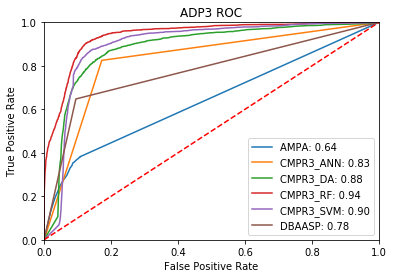

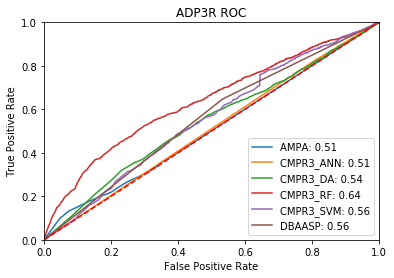

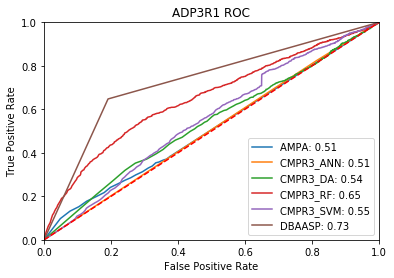

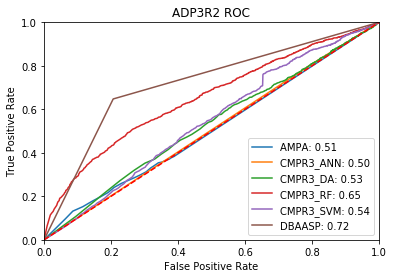

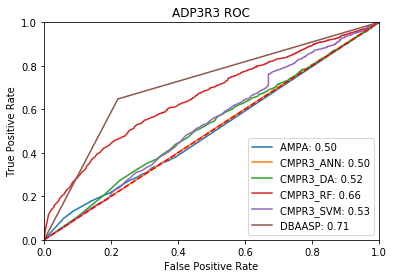

In [9]:
for r in REVERSE:
    plot_roc('ADP3', 'A', r)

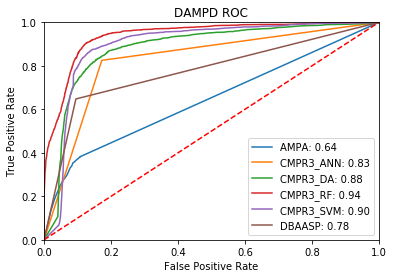

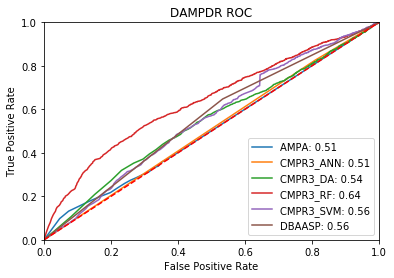

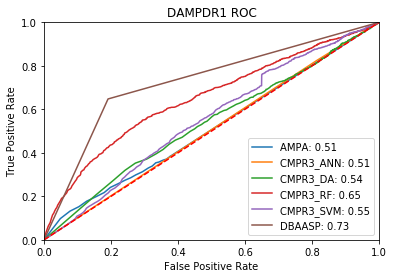

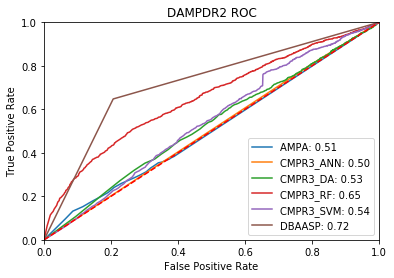

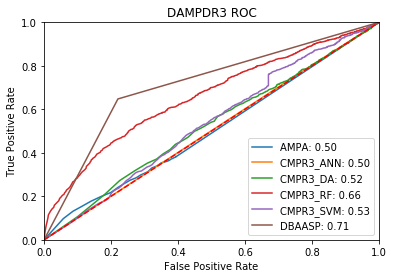

In [10]:
for r in REVERSE:
    plot_roc('DAMPD', 'D', r)

## Feature Dependence Analysis

### Length vs Prediction Probability

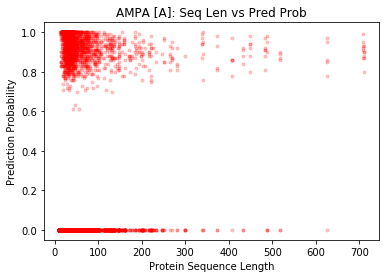

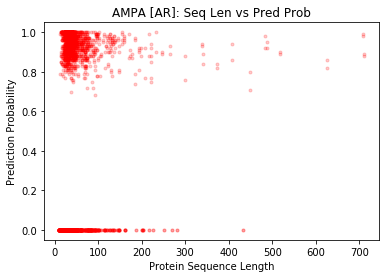

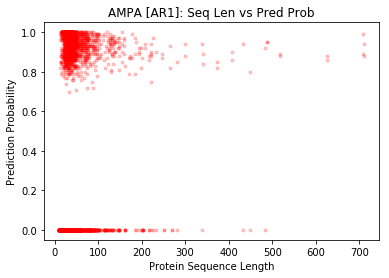

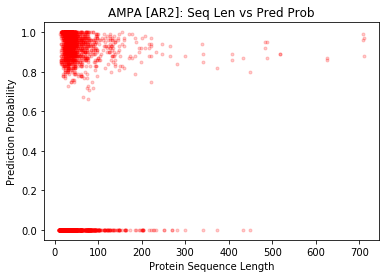

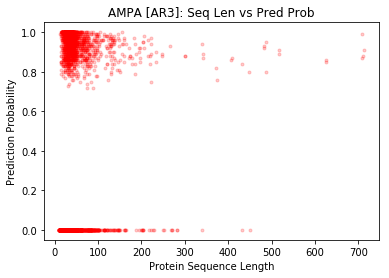

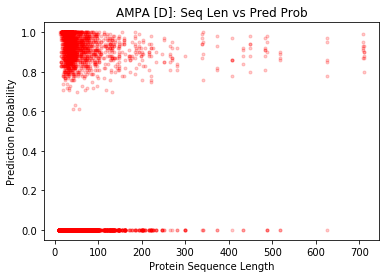

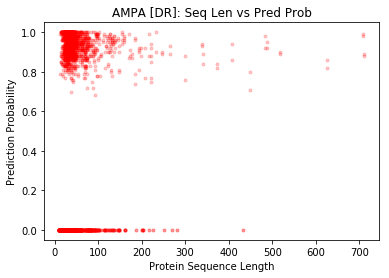

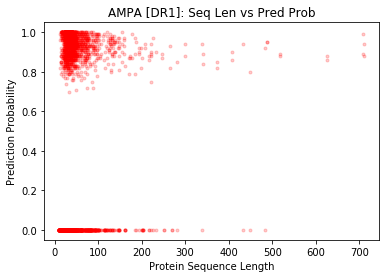

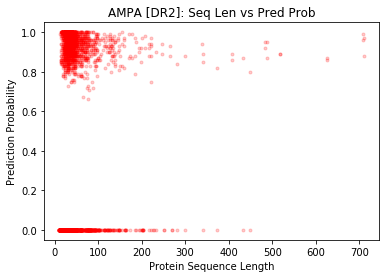

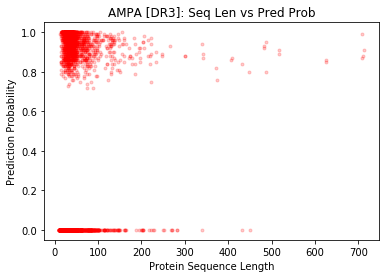

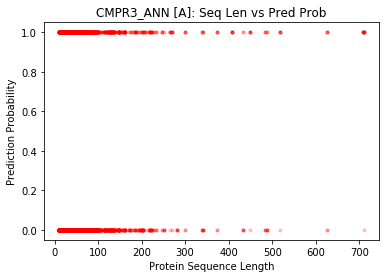

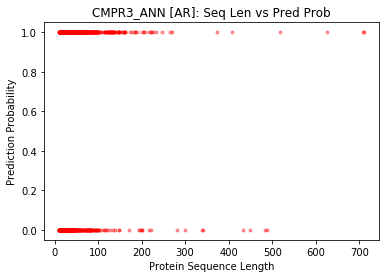

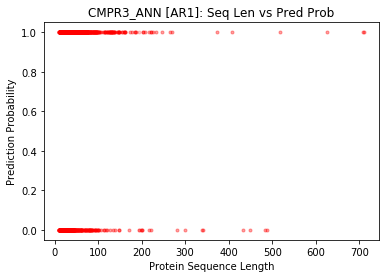

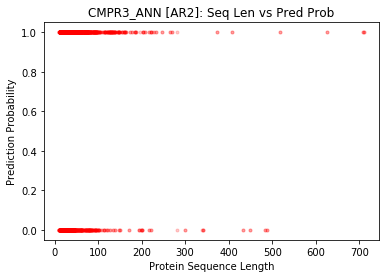

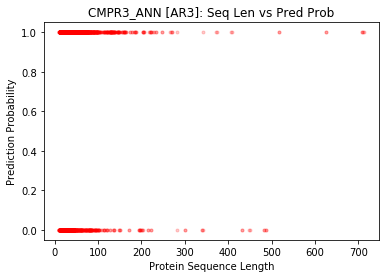

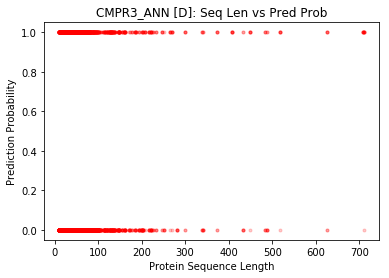

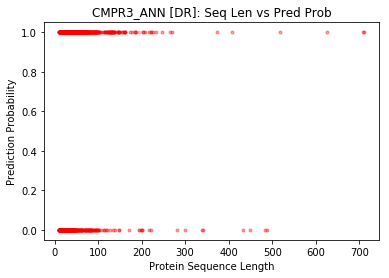

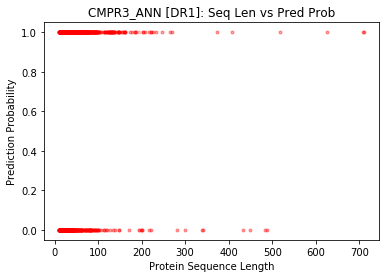

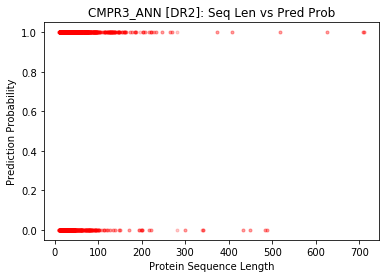

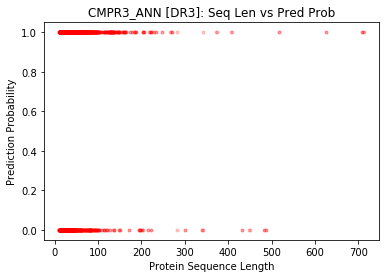

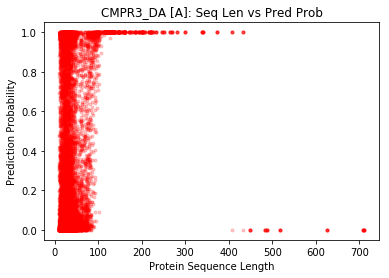

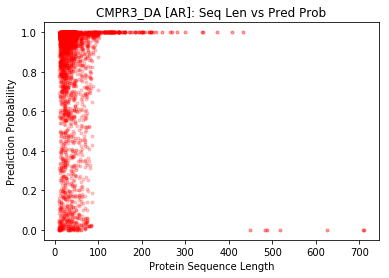

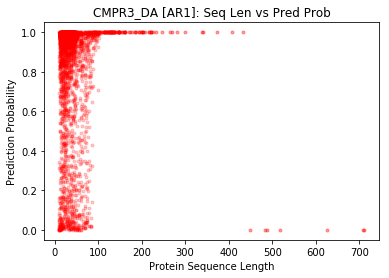

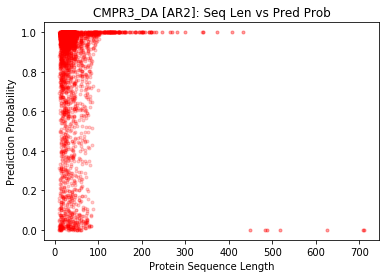

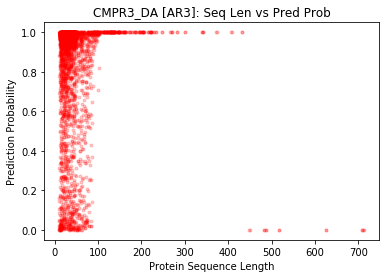

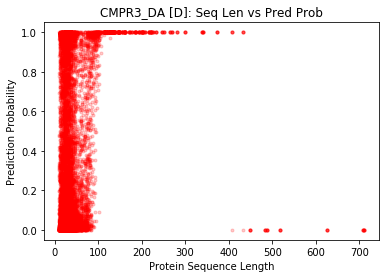

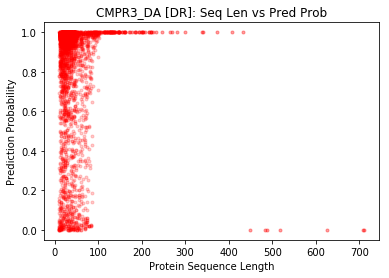

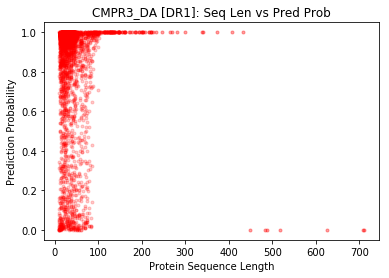

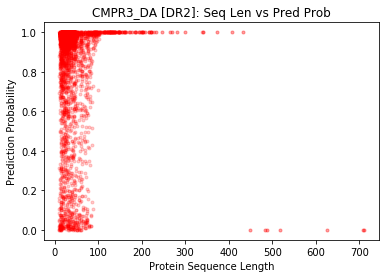

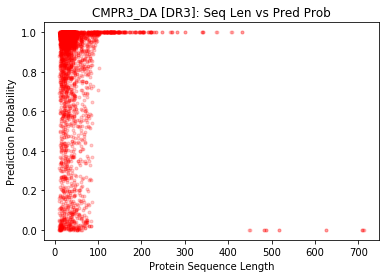

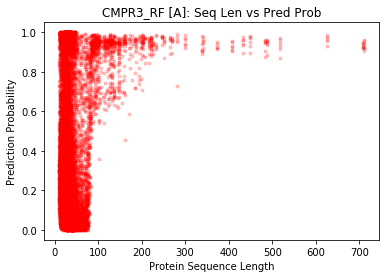

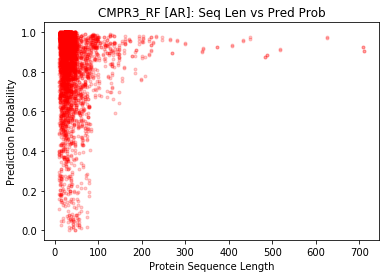

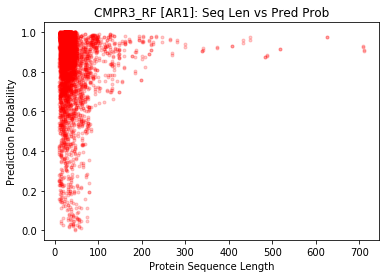

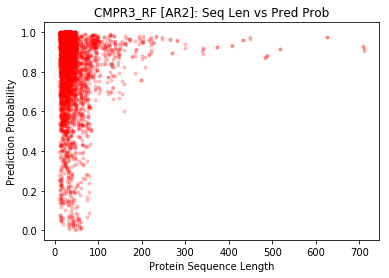

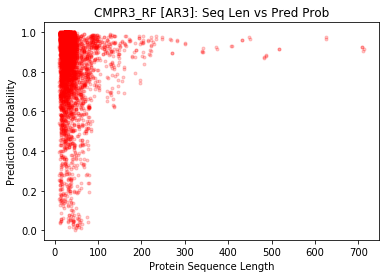

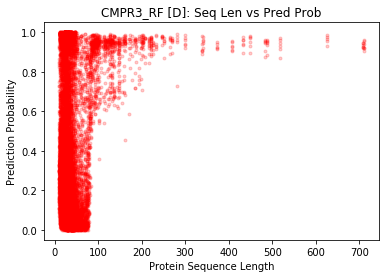

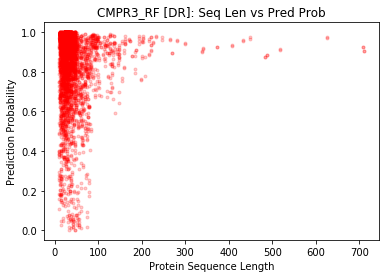

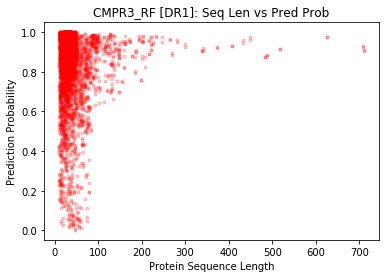

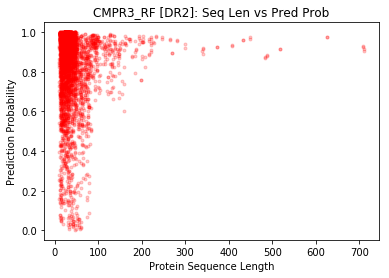

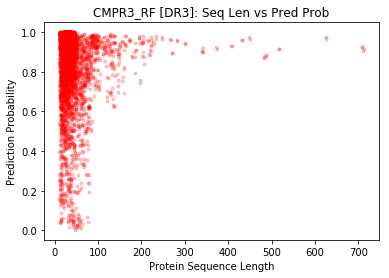

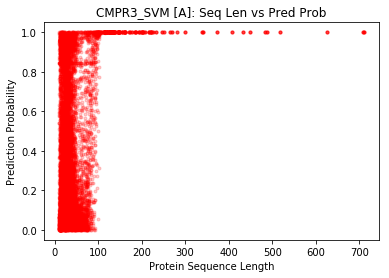

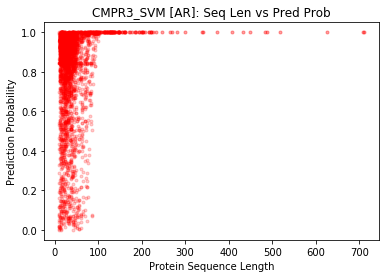

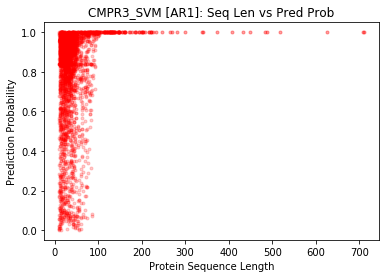

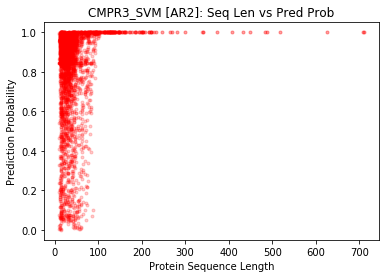

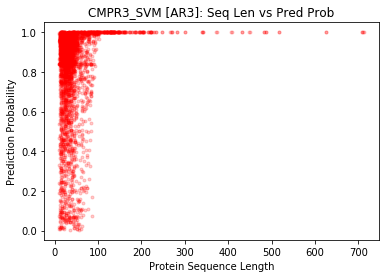

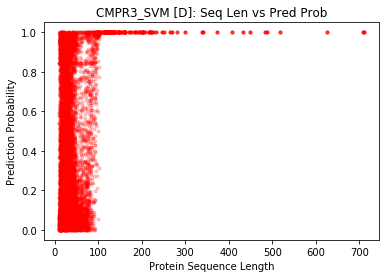

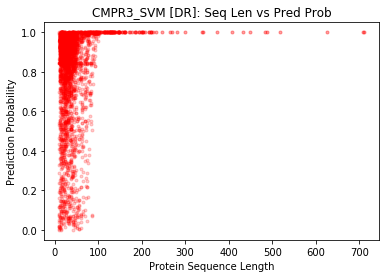

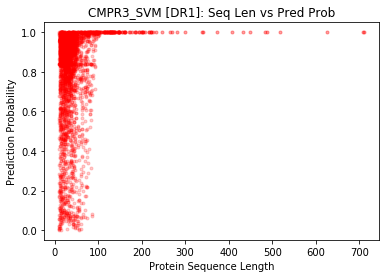

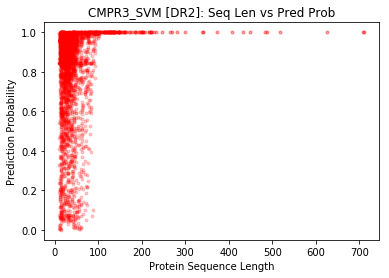

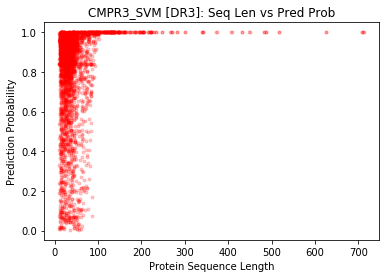

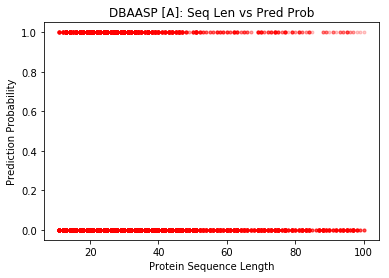

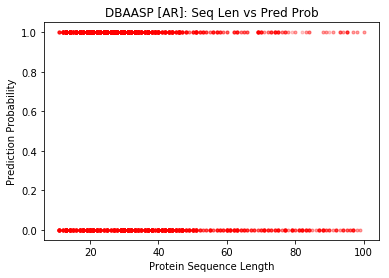

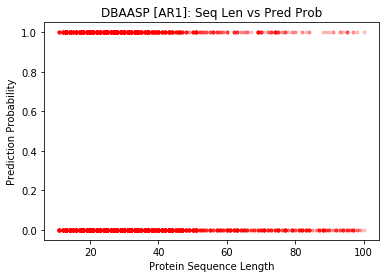

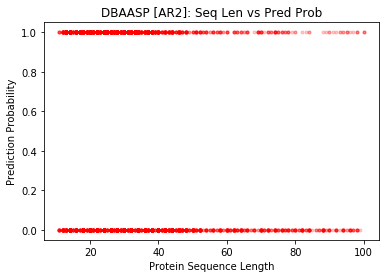

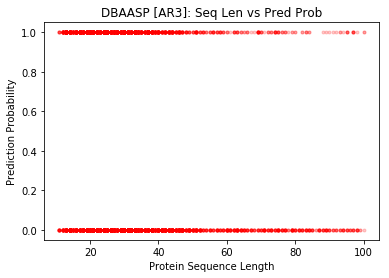

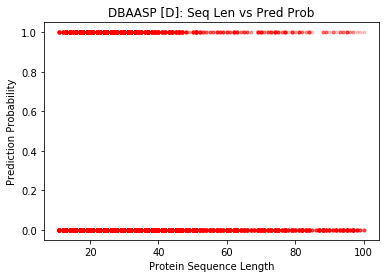

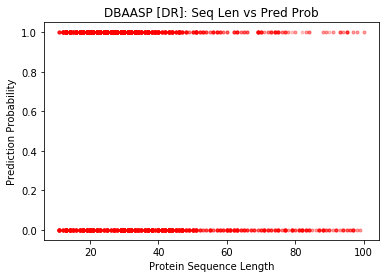

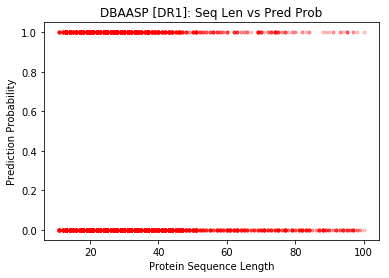

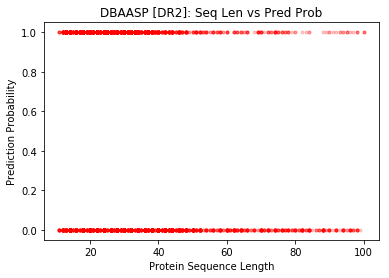

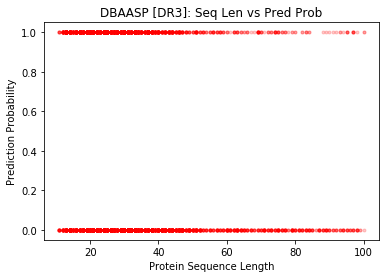

In [11]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            plt.title(s + ' ['+d+r+']' + ': Seq Len vs Pred Prob')
            plt.plot(data[s][d][r]['PepSeq'].apply(len), data[s][d][r]['PredScore'], 'r.', alpha=0.2)
            plt.xlabel('Protein Sequence Length')
            plt.ylabel('Prediction Probability')
            plt.show()

### Number of Unique Protein Count vs Prediction Probability

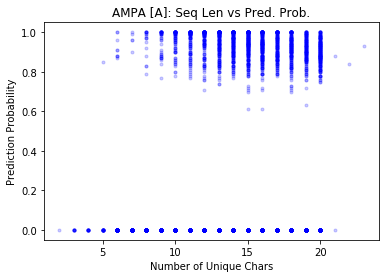

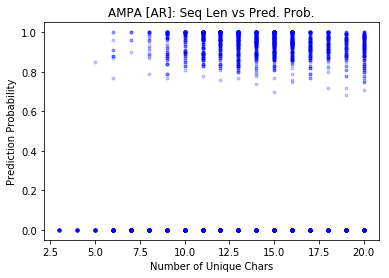

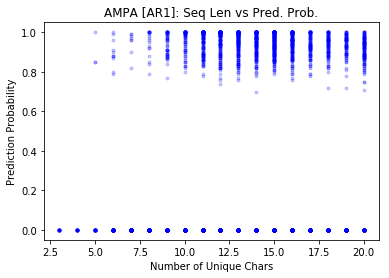

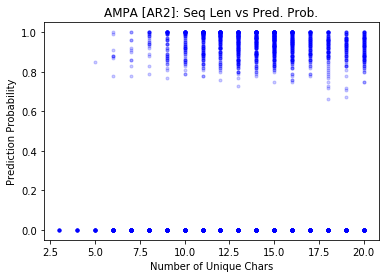

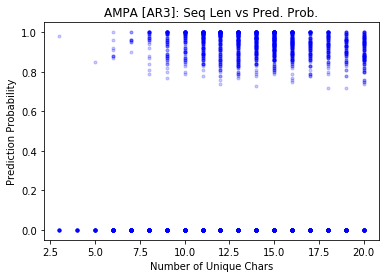

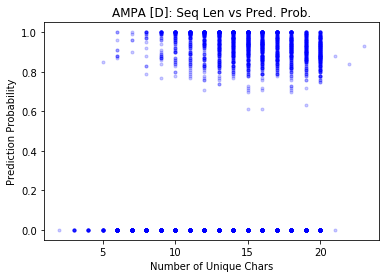

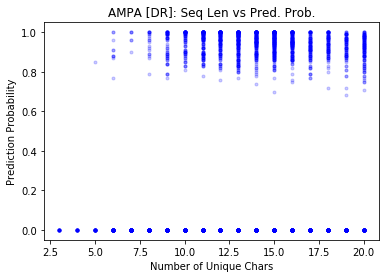

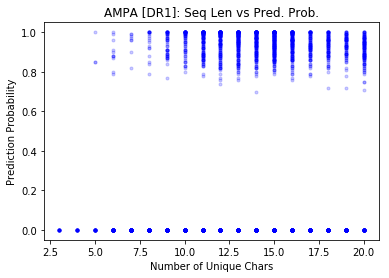

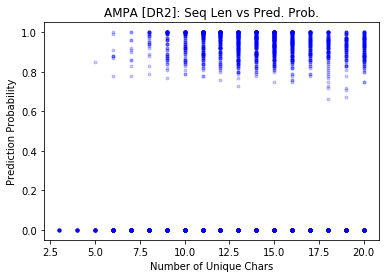

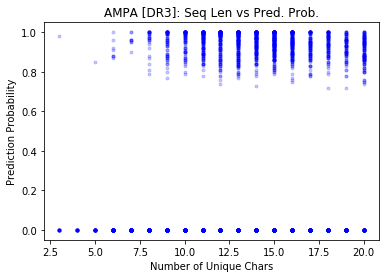

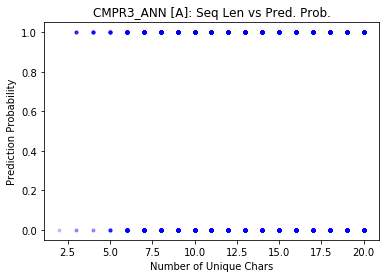

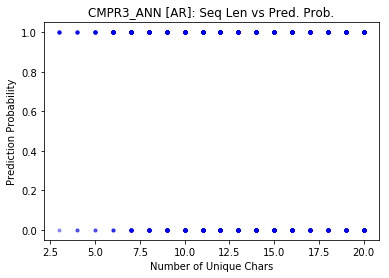

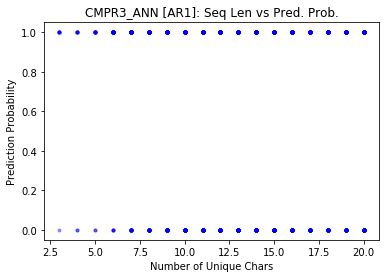

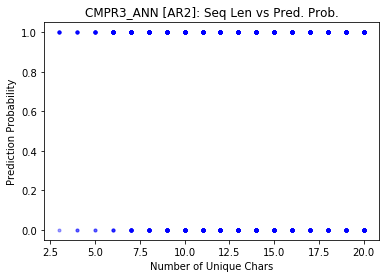

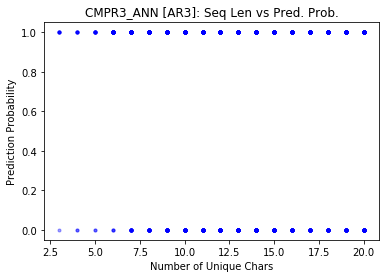

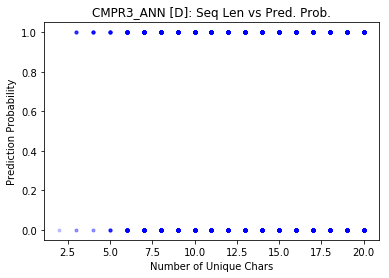

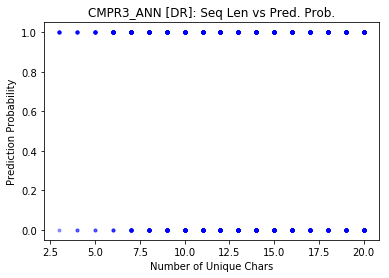

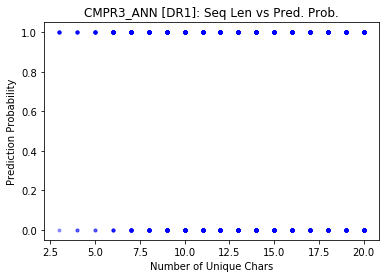

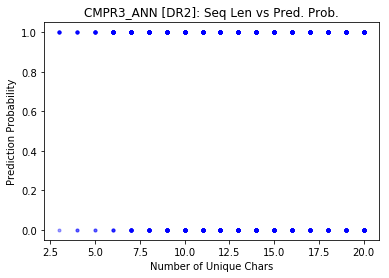

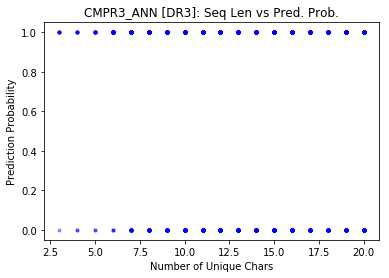

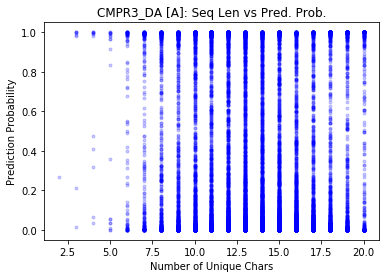

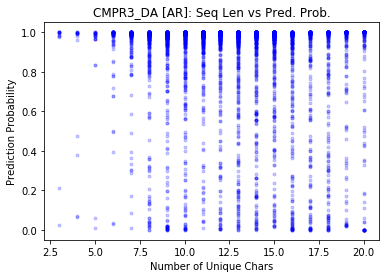

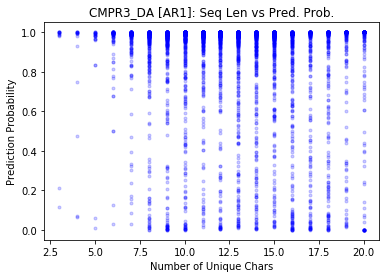

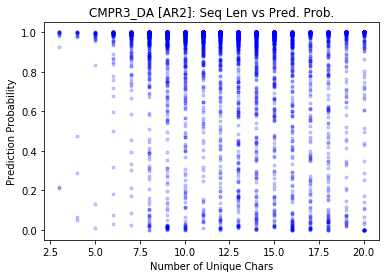

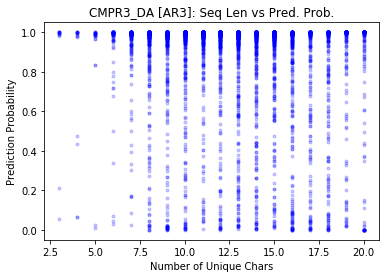

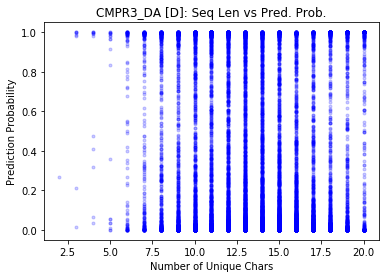

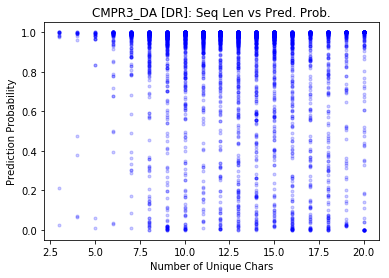

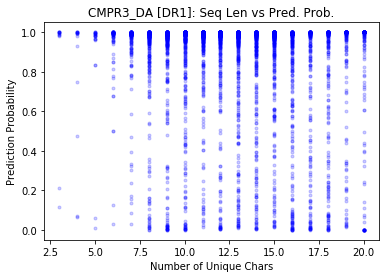

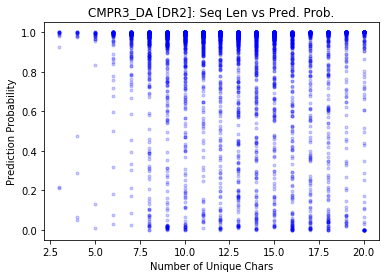

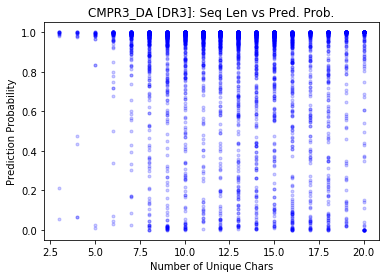

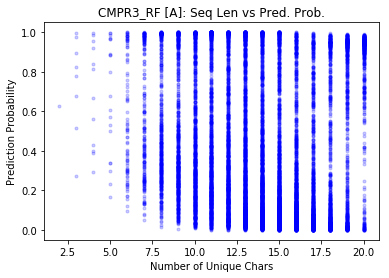

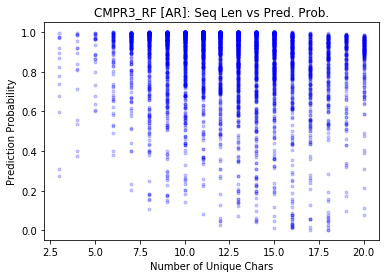

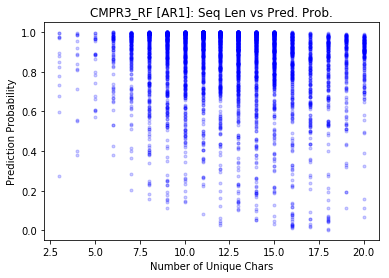

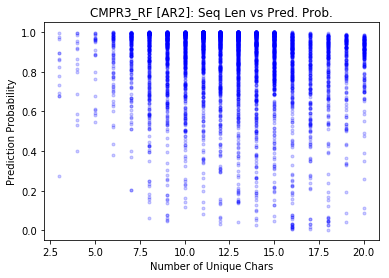

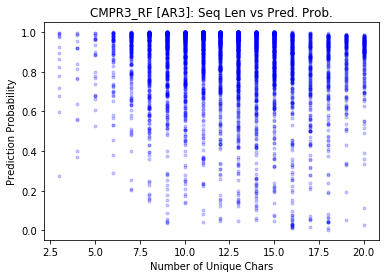

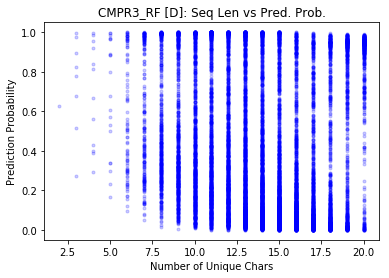

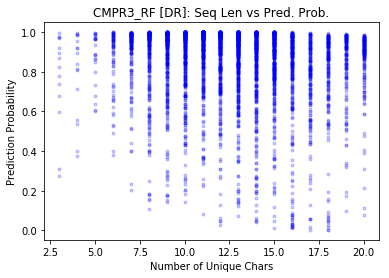

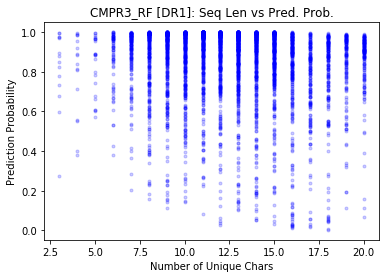

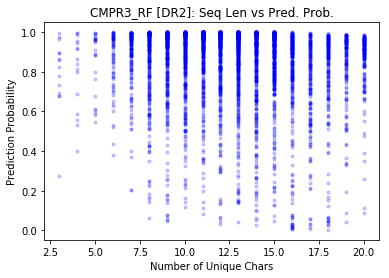

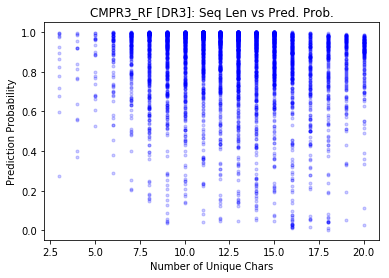

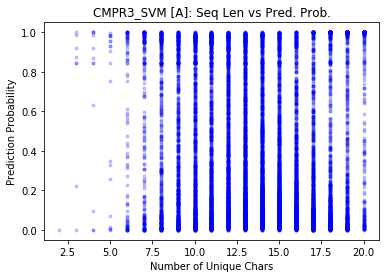

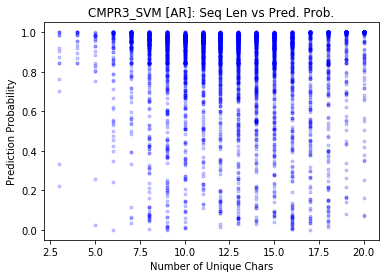

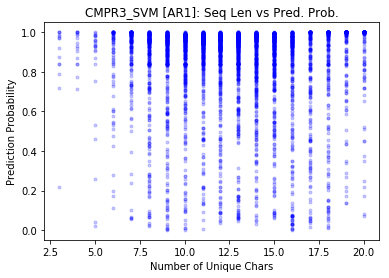

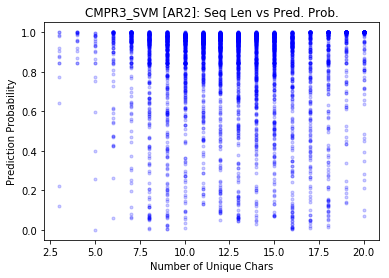

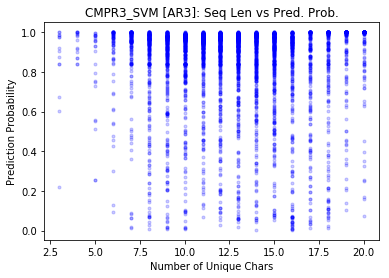

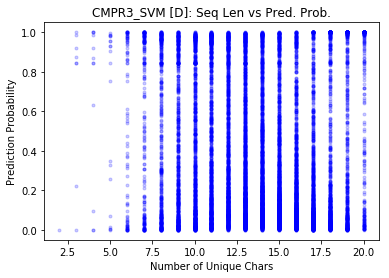

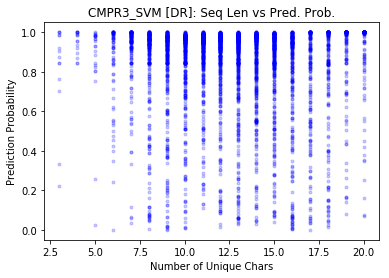

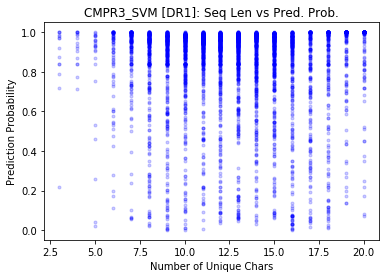

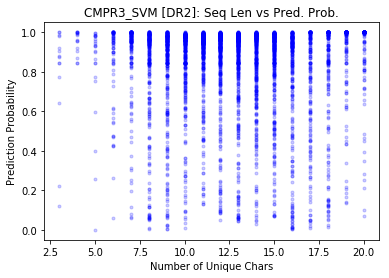

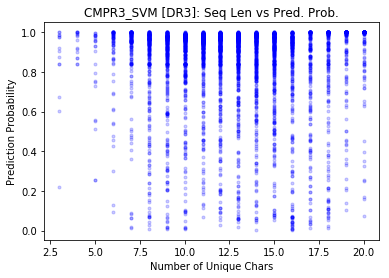

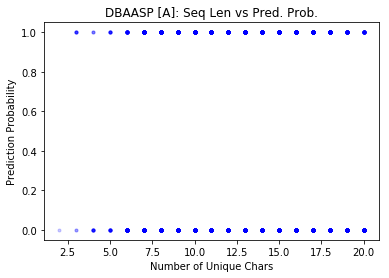

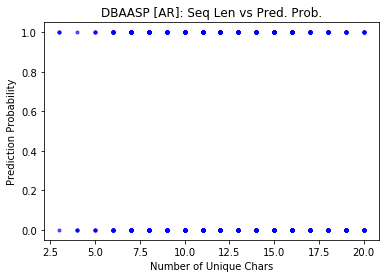

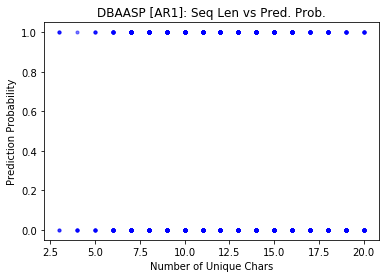

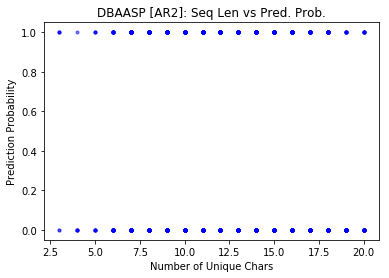

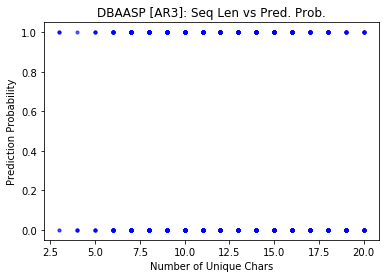

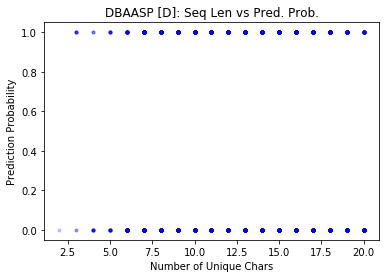

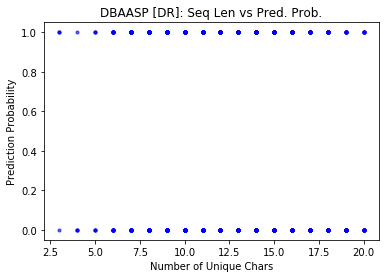

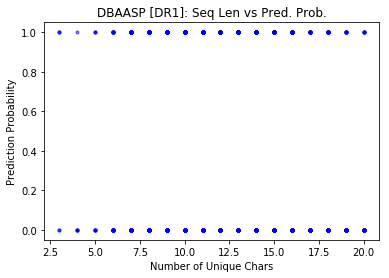

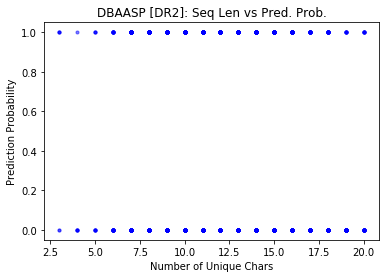

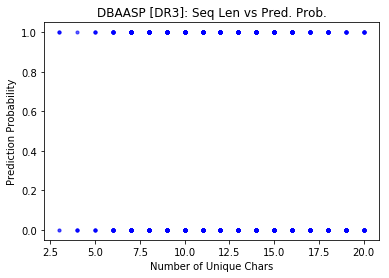

In [12]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            plt.title(s + ' ['+d+r+']' + ': Seq Len vs Pred. Prob.')
            plt.plot(data[s][d][r]['PepSeq'].apply(lambda x: len(set(x))), data[s][d][r]['PredScore'], 'b.', alpha=0.2)
            plt.xlabel('Number of Unique Chars')
            plt.ylabel('Prediction Probability')
            plt.show()